## Experimental demonstration of arbitrage versus real-world expectation

In [5]:
%reset -f
# use widget for binder
%matplotlib widget  
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import math
import ipympl

S0 = 2  # initial stock price
B0 = 1  # initial bond price
u = 50  # uptick multiplier
d = 0.5 # downtick multiplier
K = 2   # strike
T = 1   # maturity
r = 0   # risk-free rate
p = 0.8 # real world probability of uptick

Su=u*S0 # uptick stock value
Sd=d*S0 #downtick stock payoff

Cu=max(Su-K,0.) # uptick call payoff
Cd=max(Sd-K,0.) #downtick call payoff

In [22]:
# run repeated experimental trials

n = 100 #number of trials

x = np.zeros(n)
ps = np.random.randn(n)

rng = np.random.default_rng()
s = rng.binomial(1, p, n) # single sample, repeated n times: 1 for uptick, 0 for down

def callpayoff(uptick):
    if uptick==1: 
        payoff=Cu
    else:
        payoff=Cd
    return(payoff)

callpayoffv = np.vectorize(callpayoff) # vectorize
callpayoffs = callpayoffv(s)

print('The payoffs for the trails are: ', *callpayoffs)

callpvs = math.exp(-r*T)*callpayoffs # present values of individual payoffs

The payoffs for the trails are:  98 0 0 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 0 98 98 98 98 98 98 98 98 98 98 0 98 98 98 0 98 98 98 98 0 98 98 98 98 98 98 98 0 0 98 98 98 98 98 98 98 98 98 98 98 0 98 98 98 98 0 98 98 98 0 98 98 98 98 0 98 0 0 98 0 98 98 98 98 0 0 98 98 98 98 0 98 98 98 98 98 98 98 98


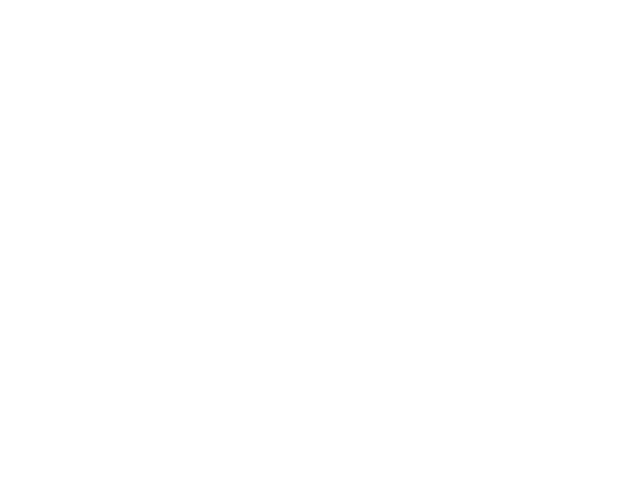

In [7]:

def updatecallpvs(curr):
    if curr == n:
        a.event_source.stop()
    plt.cla()
    bins = np.arange(-100, 200, 10)
    plt.hist(callpvs[:curr], bins = bins)
    plt.axis([-100, 200, 0, 100])
    plt.gca().set_title('present values of call payoffs')
    plt.gca().set_ylabel('frequency')
    plt.gca().set_xlabel('value')
    plt.gca().annotate('n={}\nmean pv={}'.format(curr,np.mean(callpvs[:curr+1])), [-50, 50])


fig = plt.figure()
a = animation.FuncAnimation(fig, updatecallpvs, interval = 100)

plt.show()

In [8]:
callvalue=float(input('Enter market price of call ')) # guess something for experiment
print(callvalue)



Enter market price of call  50


50.0


# Make some money

We will try to take advantage of any mispricing of the call option here.

The idea is that we expose ourselves to the risk of the call option by short-selling one and try to balance the risk exactly by taking on stocks and bonds. 

If the balancing is done correctly, we end up in exactly the same situation cash-wise no matter what happens when the call matures.

*If* there was over/under pricing of the call then we have the same surplus/deficit every time. This is called an arbitrage.


In [17]:
#set up hedge
phi1=(Cu-Cd)/(Su-Sd)
psi1=math.exp(-r*T)*(Cu-phi1*Su)/B0
hedgecost=phi1*S0+psi1*B0
print('Setting up our hedge of {:.2f} stocks and {:.2f} bonds costs {:.2f}'.format(phi1,psi1,hedgecost))

initialnetcash=callvalue-hedgecost
print('We get {:.2f} from selling a call, so initial surplus cash is {:.2f}'.format(callvalue,initialnetcash))

def hedgepayoff(uptick):
    if uptick==1: 
        payoff=phi1*Su+psi1*math.exp(r*T)*B0
    else:
        payoff=phi1*Sd+psi1*math.exp(r*T)*B0
    return(payoff)

hedgepayoffv = np.vectorize(hedgepayoff) # vectorize
hedgepayoffs = hedgepayoffv(s)
hedgepvs=math.exp(-r*T)*hedgepayoffs


payoffpvs=hedgepvs-callpvs

netpvs=initialnetcash+payoffpvs

Setting up our hedge of 0.99 stocks and -0.99 bonds costs 0.99
We get 50.00 from selling a call, so initial surplus cash is 49.01


# See what happens for each of the trials

We are plotting the present values of the payoffs from the calls in black - how much we owe on the short sell, and the hedge in yellow - how much we get from the stocks and bonds.

Notice that they are always the same. This means we can *always* use the hedge to cover what we owe on the short sell.

The present value of our overall position (i.e. the sum of our surplus cash, the short and the hedge) is plotted in red. This is just the surplus cash every time. We *always* have a PV of the initial cash. There is no uncertainty in this - we say no risk - we call this an arbitrage.


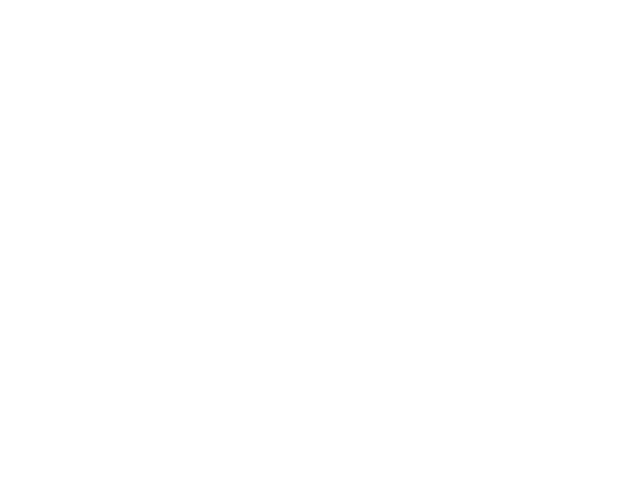

In [18]:
def updatenetpvs(curr):
    if curr == n:
        a.event_source.stop()
    plt.cla()
    bins = np.arange(-25, 125, 20)
    #plt.hist(netpvs[:curr], alpha=0.5,bins = bins,label='netpvs')
    #plt.hist(callpvs[:curr], alpha=0.5,bins = bins,label='callpvs')
    #plt.hist(hedgepvs[:curr], alpha=0.5,bins = bins,label='hedgepvs')
    plt.hist(np.dstack((netpvs[:curr],callpvs[:curr],hedgepvs[:curr]))[0], bins = bins, color = ['red', 'black', 'yellow'],label=['netpvs','callpvs','hedgepvs'])
    plt.axis([-25, 125, 0, 100])
    plt.gca().set_title('present values of net position')
    plt.gca().set_ylabel('frequency')
    plt.gca().set_xlabel('value')
    plt.gca().annotate('n={}\nmean pv={}'.format(curr,np.mean(netpvs[:curr+1])), [0, 80])
    plt.legend()
    

fig = plt.figure()
a = animation.FuncAnimation(fig, updatenetpvs, interval = 500)

plt.show()
